<a href="https://colab.research.google.com/github/jav0927/course-v3/blob/master/JAV_SSD_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
NUM_PARALLEL_UNITS = 4
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["KMP_BLOCKTIME"] = "0"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine, verbose, compact, 1, 0"

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.vision import *
from fastai import *
from fastai.callbacks import *


In [0]:
# Download {Pasal 20007 database}
path = untar_data(URLs.PASCAL_2007); path.ls()

[PosixPath('/root/.fastai/data/pascal_2007/train.json'),
 PosixPath('/root/.fastai/data/pascal_2007/valid.json'),
 PosixPath('/root/.fastai/data/pascal_2007/test.json'),
 PosixPath('/root/.fastai/data/pascal_2007/train'),
 PosixPath('/root/.fastai/data/pascal_2007/test')]

### Data Preparation

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

In [0]:
# Collect image names, bound box coordinates, and categories into lists
# for train and test data sets
trn_im_names, trn_truths = get_annotations(path/'train.json')
val_im_names, val_truths = get_annotations(path/'valid.json')
tst_im_names, tst_truths = get_annotations(path/'test.json') 

# Combine Train and Validation set into a sigle dataset
# (which will be split later by the data block)
tot_im_names, tot_truths = [trn_im_names + val_im_names, trn_truths + val_truths]

# Create a dictionary containing the composite of the above
img_y_dict = dict(zip(tot_im_names, tot_truths))

# Define a function, based on the dictionary created above, to use in a Fastai Data Block to structure the input data
truth_data_func = lambda o: img_y_dict[o.name]

### Create Fastai DataBunch

In [0]:
sz=224       # Image size
bs=64        # Batch size

In [0]:
np.random.seed(35)
tfms = get_transforms(max_rotate=3.,max_zoom=1.,p_affine=0.5,p_lighting=0.5)
data = (ObjectItemList
        .from_folder(path/'train')
        .split_by_rand_pct(0.1)
        .label_from_func(truth_data_func)
        .transform(tfms=tfms,size=sz,tfm_y=True,resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs,collate_fn=bb_pad_collate,num_workers=8)
        .normalize(imagenet_stats)
       )

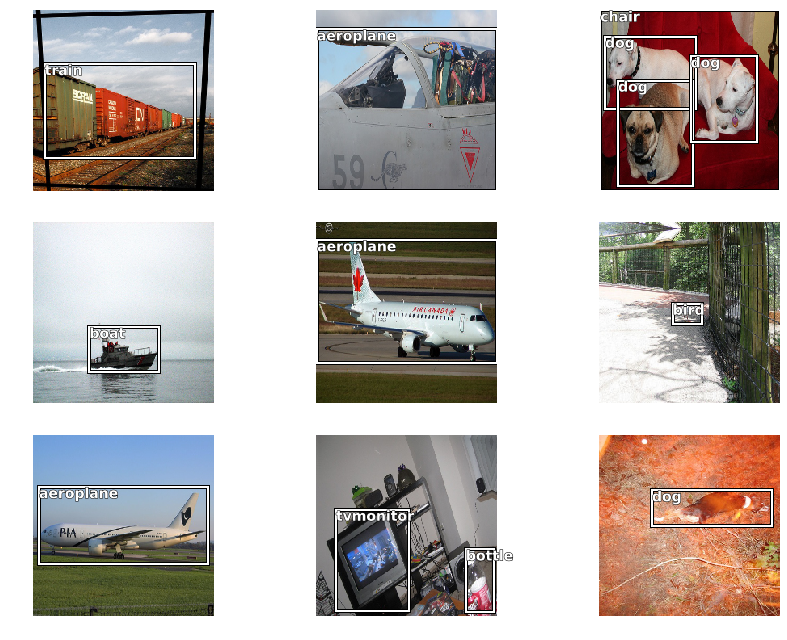

In [0]:
data.show_batch(rows=3, figsize=(12,9))

### Show single simple image

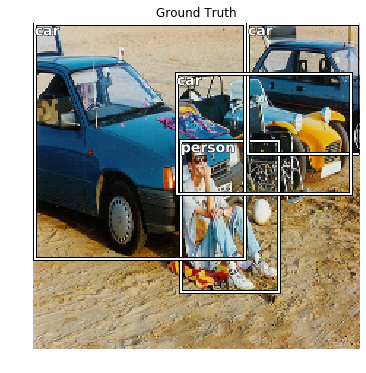

In [0]:
idx = 9

xb, yb= next(iter(data.valid_dl))

img = vision.Image(denormalize(xb[idx], *tensor(imagenet_stats)))
img_box = ImageBBox.create(sz, sz, yb[0][idx].cpu(), labels=yb[1][idx], classes=data.classes, scale=False)

fig, axes = plt.subplots(1, 1, figsize=(10,6))
img.show(ax=axes, y=img_box, title="Ground Truth")

### Helper Functions - Bounding Boxes and Anchors

In [0]:
# Filter all zero-valued bounding boxes
def un_pad(boxes,labels):
    bb_keep = ((boxes[:,2] - boxes[:,0])>0).nonzero()[:,0]
    return boxes[bb_keep],labels[bb_keep]

# Calculate the area of a bounding box
def box_area(boxes):
    return (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])

# Calculate the intersection of two given bounding boxes
def intersect(box_a,box_b):
    #make sure box_a and box_b exists, otherwise undefine behavior if you call the func
    top_left = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    bot_right = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp((bot_right - top_left),min=0)
    return inter[:,:,0] * inter[:,:,1]

# Calculate Jaccard
def iou(bbox,anchor):
    #bbox is gt_bb, anchor is anchor box, all in fastai style
    if len(bbox.shape) == 1: bbox = bbox[None,...]
    inter = intersect(bbox,anchor)
    union = box_area(bbox).unsqueeze(dim=1) + box_area(anchor).unsqueeze(dim=0) - inter #to broadcast shape to (N,16),where N is number of gt_bb for single image
    return inter / union

# Display generated anchor grid
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid(True, which='both')
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

#convert center/height/width to fastai style: top left bot and bottom right anchor box
def cthw2corners(boxes):
    top = (boxes[:,0] - boxes[:,2]/2).view(-1,1)
    left = (boxes[:,1] - boxes[:,3]/2).view(-1,1)
    bot = (boxes[:,0] + boxes[:,2]/2).view(-1,1)
    right = (boxes[:,1] + boxes[:,3]/2).view(-1,1)
    return torch.cat([top,left,bot,right],dim=1)

# Transform activations to boundin box format
#anchor (center,h,w)
#fastai y (top left bot right)
#convert activation to fastai y style
#assume activation is (center,h,w)
def act_to_bbox(activation,anchor):
    activation = torch.tanh(activation) #force scale to be -1,1
    act_center = anchor[:,:2] + (activation[:,:2]/2 * grid_sizes.float().to(activation.device))
    act_hw = anchor[:,2:] * (activation[:,2:]/2 + 1)
    return cthw2corners(torch.cat([act_center,act_hw],dim=1))

def map_to_gt(overlaps):
    prior_overlap,prior_idx = overlaps.max(dim=1)
    sec_overlap,sec_idx = overlaps.max(dim=0)
    sec_overlap[prior_idx] = 4.99
    for i,o in enumerate(prior_idx): 
        sec_idx[o] = i
    return sec_overlap,sec_idx

### Helper Functions - Original

In [0]:

anc_grids = [4, 2, 1]
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms 
                                    for (i,j) in anc_ratios]
# *** Number of Anchor Scales
k = len(anchor_scales)
# ***************************

anc_offsets = [2/(o*2) for o in anc_grids] #2 is the h,w in fastai 1.0 (-1,1)
anc_x = np.concatenate([np.repeat(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes = np.concatenate([np.array([[2*o/ag,2*p/ag] 
              for i in range(ag*ag) for o,p in anchor_scales])
                 for ag in anc_grids]) #2/grid * scale,2 is the h,w in fastai 1.0
grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
              for i in range(ag*ag) for o,p in anchor_scales])
                  for ag in anc_grids])).unsqueeze(1) *2 #again fastai 1.0 h,w is 2
anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()
anchor_cnr = cthw2corners(anchors)


### Helper Functions - Revised

In [0]:
''''
anc_grids = [4, 2, 1]
anc_zooms = [0.7, 1., 1.3]
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms 
                                    for (i,j) in anc_ratios]
# *** Number of Anchor Scales
k = len(anchor_scales)
# ***************************

anc_offsets = [1/(o*2) for o in anc_grids] #2 is the h,w in fastai 1.0 (-1,1)
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes = np.concatenate([np.array([[o/ag,p/ag] 
              for i in range(ag*ag) for o,p in anchor_scales])
                 for ag in anc_grids]) #2/grid * scale,2 is the h,w in fastai 1.0
grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
              for i in range(ag*ag) for o,p in anchor_scales])
                  for ag in anc_grids])).unsqueeze(1) #again fastai 1.0 h,w is 2
anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()
anchor_cnr = cthw2corners(anchors)
'''

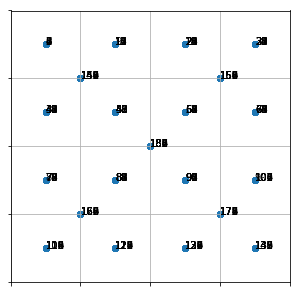

In [0]:
show_anchors(anchors,(4,4))

### Optimal Learning Rate Search

In [0]:
def find_optimal_lr(learn, plot=False):
   
    #Get loss values, corresponding gradients, and lr values from model.recorder
    loss = np.array(learn.recorder.losses)
    loss_grad = np.gradient(loss)
    lrs = learn.recorder.lrs    
    # Transform lrs list to np array
    lrs = np.array(lrs, dtype='float32')
    
    # Create a DataFrame with the data
    df = pd.DataFrame(columns=['loss', 'loss_grad', 'lrs', 'min_loss', 'max_loss', 'min_grad', 'max_grad'])
    for i, (ls, lg, lr) in enumerate(zip(loss, loss_grad, lrs)):
      df.at[i,'loss'] = ls; df.at[i,'loss_grad'] = lg; df.at[i,'lrs'] = lr
    # Populate "min" and "max" columns for losses and gradients
    from scipy.signal import argrelextrema
    n=10  #4
    df['min_loss'] = df.iloc[argrelextrema(df.loss.values, np.less_equal, order=n)[0]]['loss']
    df['max_loss'] = df.iloc[argrelextrema(df.loss.values, np.greater_equal, order=n)[0]]['loss']
    df['min_grad'] = df.iloc[argrelextrema(df.loss_grad.values, np.less_equal, order=n)[0]]['loss_grad']
    df['max_grad'] = df.iloc[argrelextrema(df.loss_grad.values, np.greater_equal, order=n)[0]]['loss_grad']

    # Plot losses and loss gradients against lr values
    plt.figure()
    #figs, ax = plt.subplots(1,1)
    ax = plt.gca()
    color1 = 'blue'
    color2 = 'orange'

    ax.xaxis.grid(True)
    ax.set_ylabel('Loss')
    ax.set_title('Learn Rate Finder')
    ax.tick_params(axis='y', labelcolor=color1)
    ax.semilogx(df['lrs'], df.loss, c=color1 )
    
    # Upper limit to the size of the plot window
    u_limit = max(df.loss.loc[(df.lrs < 0.1)].max(), 250)*2    
    ax.set_ylim([-200, u_limit])
   
    ax2 = ax.twinx()
    ax2.set_ylabel('loss', color=color2)
    ax2.semilogx(df['lrs'], df.loss_grad, c=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    ax.scatter(df['lrs'], df['min_loss'], c='r')
    ax.scatter(df['lrs'], df['max_loss'], c='g')
    ax2.scatter(df['lrs'], df['min_grad'], c='r')
    ax2.scatter(df['lrs'], df['max_grad'], c='g')
    plt.LogFormatter(labelOnlyBase=False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=3, fancybox=True, shadow=True)
    plt.show()
    
    optimun_lr_lower_bound = df.lrs.iloc[df.loss_grad.notna()[::-1].idxmax()]/10
    optimun_lr_upper_bound = df.lrs.iloc[df.loss.notna()[::-1].idxmax()]
    print('Optimun lr: {} '.format(optimun_lr_upper_bound))
    print('Lowest loss lr interval: [{} , {}]'.format(optimun_lr_upper_bound, optimun_lr_lower_bound))
    
    return optimun_lr_upper_bound  

### Model

To solve this object detection problem, we are going to create a custom model using Torch.
The architecture chosen is Single Shot Detection, described in the paper SSD: Single Shot Multibox Detector by Wei Liu, et. al.
The model uses a pretrained ResNet, to which we add the components required for object detetion. For initial design and testing, we use ResNet18, as it is computationally lighter (and I dont have a GPU). It will be upgraded when we do further tests.

In [0]:
# Number of classes in the data set
no_cls = len(data.classes); no_cls

21

In [0]:
# model 
f_model = models.resnet34

In [0]:
# Method used to match the shape of the conv_ssd_layer to the ground truth's shape
def y_handoff (x,k):
    # Reshape ssd output to match truth's shape 
    # Must return size of bs,r*c,nf
    # y structure is (16,4),(16,21) single item style
    bs,nf,row,col = x.shape
    x = x.view(bs,nf//k,-1)
    return x.permute(0,2,1)
    

# Standard convolution with stride=2 to halve the size of the image
class conv2_std_layer(nn.Module):
    def __init__(self, ni, nf, stride=2, drop=0.1):
        super().__init__()
        self.cnv = conv_layer(ni, nf, stride=stride)
        self.drp = nn.Dropout(drop)
        
    def forward(self, x):
        return self.drp(self.cnv(x))

# SSD convolution that camptures bounding box and class
class conv2_ssd_layer(nn.Module):
    def __init__(self, ni, k, no_cls):
        super().__init__()
        self.k = k 
        self.conv_class = conv2d(ni, no_cls*self.k, bias=True)
        self.conv_bbox = conv2d(ni, 4*self.k, bias=True)
        #self.conv_class.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        label = self.conv_class(x)
        box = self.conv_bbox(x)
        return [y_handoff(box, self.k), y_handoff(label, self.k)]

In [0]:
class ssd_model(nn.Module):
    def __init__(self, arch=models.resnet34, k=9 , drop=0.4, no_cls=21):
        super().__init__()
        self.k = k
        self.body = create_body(arch)
        self.drop = nn.Dropout(drop)   # it was 0.25

        self.std_conv_0 = conv2_std_layer(num_features_model(self.body), 256, drop=drop,stride=1) # H=7, W=7
        self.std_conv_1 = conv2_std_layer(256, 256, drop=drop, stride=2) # 4 x 4
        self.std_conv_2 = conv2_std_layer(256, 256, drop=drop, stride=2) # 2 x 2
        self.std_conv_3 = conv2_std_layer(256, 256, drop=drop, stride=2) # 1 x 1
        self.ssd_conv_1 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        self.ssd_conv_2 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        self.ssd_conv_3 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        
    def forward(self, xb):
        xb = self.drop(F.relu(self.body(xb)))
        xb = self.std_conv_0(xb)
        xb = self.std_conv_1(xb)
        bb1, cls1 = self.ssd_conv_1(xb) # 4 x 4
        xb = self.std_conv_2(xb)
        bb2, cls2 = self.ssd_conv_2(xb) # 2 x 2
        xb = self.std_conv_3(xb)     
        bb3, cls3  = self.ssd_conv_3(xb) # 1 x 1
        
        return [torch.cat([bb1, bb2, bb3], dim=1), 
                torch.cat([cls1, cls2, cls3], dim=1)]

### SSD Loss

---


In [0]:
# Focal loss implementation
def get_weight(x,t):
    x,t = x.cpu(),t.cpu()
    alpha,gamma = 0.25,1
    p = x.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)
    
# Class loss computation, based on Binary Cross Entrophy with Logits
def bceloss(pred,target,num_classes,focal_loss=False):
    #print(target.shape)
    t = torch.eye(num_classes)[target.detach().cpu()][:,1:]
    p = pred[:,1:]
    #print(t.shape,p.shape)
    w = get_weight(p,t) if focal_loss else None
    return F.binary_cross_entropy_with_logits(p.cpu(),t,weight=w.detach(),reduction='sum') / (num_classes-1)

# Bounding-box loss computation, based on fixed Anchor Boxes and L! Loss
def single_ssd_loss(pbox,plabel,box,label):
    #handle ground truth object, from any shape to feature map size
    anchor_box = anchors
    base_box = cthw2corners(anchor_box) #iou take both inputs in fastai style
    bbox,clas = un_pad(box,label) #y from databunch already in fastai style
    overlaps = iou(bbox,base_box.to(device))
    try:
        gt_overlaps,gt_idx = map_to_gt(overlaps)
    except:
        return 0,0
    #map gt_idx back to classes for multi label classfication
    gt_clas = clas[gt_idx]
    pos = gt_overlaps > 0.4
    gt_clas[1-pos] = len(data.classes)
    gt_label = [o.item() if o < len(data.classes) else 0 for o in gt_clas.detach()] #vector of size of # of bbox
    pos_idx = torch.nonzero(pos)[:,0] #for which cells that gt bbox exists
    gt_bbox = bbox[gt_idx]
    
    #map pred bounding box to anchor, final box = pred box + anchor box
    p_final_box = act_to_bbox(pbox,anchor_box.to(device)) #grid size over # of anchor box along single axis
    
    #L1 loss calculation
    loc_loss = ((p_final_box[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    #Multi classification
    label_loss = bceloss(plabel,tensor(gt_label),data.c,focal_loss=True)
    return loc_loss,label_loss

# Loop through each of the y_hat and y pairs 
def ssd_loss(preds,*targets,print_it=False):
    batch_loc_loss,batch_label_loss = 0., 0.
    for p_box,p_label,box,label in zip(*preds,*targets):
        loc_loss,label_loss = single_ssd_loss(p_box,p_label,box,label)
        batch_loc_loss = batch_loc_loss + loc_loss
        batch_label_loss = batch_label_loss + label_loss
    total_loss = batch_loc_loss + batch_label_loss.to(device)
    if print_it: print(batch_loc_loss,batch_label_loss)
    return total_loss

In [0]:
 loss_f = ssd_loss

### Learner

In [0]:
md = ssd_model(f_model, k=k, no_cls=no_cls)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 105464417.97it/s]


In [0]:
learn = Learner(data, md, loss_func=loss_f)

### Fit

In [0]:
# Find Finder
learn.lr_find()

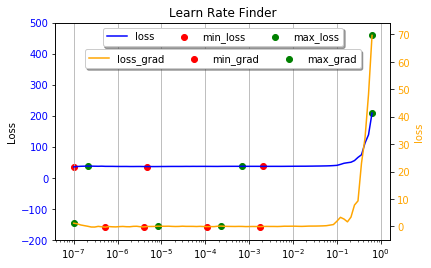

Optimun lr: 0.6309573650360107 
Lowest loss lr interval: [0.6309573650360107 , 0.06309573650360108]


In [165]:
# Find Optimal Learning Rates
lr =  find_optimal_lr(learn)

In [0]:
# FASTAI learning search
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,1059.990479,112.831833,02:53
1,245.139938,37.731411,02:51
2,87.538811,35.538788,02:50
3,50.088913,34.631783,02:49
4,40.323212,34.023762,02:49


In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_basic')

In [0]:
learn.load(F'/content/gdrive/My Drive/model-SSD/ssd_basic', strict=True)

#### Train Unfreezin layers

In [0]:
learn.split(lambda m: (m.body[7],m.drop))
learn.freeze_to(-3)

In [0]:
learn.lr_find()

In [0]:
learn.recorder.plot(suggestion=True, skip_end=35)

In [0]:
learn.fit_one_cycle(5, slice(lr/100, lr/10))

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_freeze_3')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_freeze_3', strict=True)

In [0]:
#learn.split(lambda m: (m.body[7], m.drop))
learn.unfreeze()

In [0]:
learn.lr_find()

In [0]:
learn.recorder.plot(suggestion=True,skip_end=10)

In [0]:
learn.fit_one_cycle(20, slice(lr/100, lr))

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze', strict=True)

In [0]:
learn.fit_one_cycle(20, slice(lr/10, lr))

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_2')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_2', strict=True)

In [0]:
#learn.split(lambda m: (m.body[7], m.drop))
learn.unfreeze()

In [0]:
learn.fit_one_cycle(20, slice(lr/10, lr))

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_3')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_3', strict=True)

In [0]:
#learn.split(lambda m: (m.body[7], m.drop))
learn.unfreeze()

In [0]:
learn.fit_one_cycle(20, slice(lr/10, lr))

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_4')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_4', strict=True)

In [0]:
#learn.split(lambda m: (m.body[7], m.drop))
learn.unfreeze()

In [0]:
learn.fit_one_cycle(20, slice(lr/5))

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_5')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_5', strict=True)

In [0]:
#learn.split(lambda m: (m.body[7], m.drop))
learn.unfreeze()

In [0]:
learn.fit_one_cycle(20, slice(lr/4))

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_6')

In [0]:
learn.load(F'/content/gdrive/My Drive/model-SSD/ssd_unfreeze_6', strict=True)
#learn.load(F'ssd_unfreeze_6', strict=True)

### Display predicted images and ground truth

In [0]:
# Get batch from valid dataset
xb,yb = next(iter(learn.data.valid_dl))
xb.shape

# Predict results based on the input image batch
learn.model.eval()
preds = learn.model(xb)

In [0]:
# Select sample image and unpad it
idx = 0
t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
#t_bbox,t_clas

# Predicted class
p_cls_test = preds[1][idx][:,1:].max(dim=1)
#p_cls_test

# Threshold
idx_clas = p_cls_test[0].sigmoid() > 0.1
#idx_clas


p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
#p_f_clas

In [0]:
def show_img_by_ndx(idx):
    t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
    p_cls_test = preds[1][idx][:,1:].max(dim=1)
    idx_clas = p_cls_test[0].sigmoid() > 0.1
    p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))
    img_box = ImageBBox.create(224,224,yb[0][idx].cpu(),labels=yb[1][idx],classes=data.classes,scale=False)


    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors)
    t_bbox = p_final_bbox.to(device).index_select(dim=0,index=idx_clas.nonzero().squeeze())
    test_clas = p_f_clas.index_select(dim=0,index=idx_clas.nonzero().squeeze())
    p_img_box = ImageBBox.create(224,224,t_bbox.cpu(),test_clas,classes=data.classes,scale=False)

    fig,axes = plt.subplots(1,2,figsize=(10,6))
    img.show(ax=axes[0],y=img_box,title='Ground Truth')
    img.show(ax=axes[1],y=p_img_box,title='Prediction')

In [0]:
show_img_by_ndx(14)

In [0]:
show_img_by_ndx(2)

### Filter Spurious Boxes

In [0]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

### NMS

In [0]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

### Filtering Method

In [0]:
# Get batch from valid dataset
xb,yb = next(iter(learn.data.valid_dl))

# Predict results based on the input image batch
learn.model.eval()
preds = learn.model(xb)
b_bb, b_clas = preds

In [0]:
def process_nmf(idx):
    '''
    Connects to the nmf algorith to filter out dupplicate bounding boxes
    ''' 
    # Minimun threshold for eliminating background noise
    min_thresh = 0.30     #0.25
    
    # Maximun threshold for eliminating duplicate boxes
    max_thresh = 0.1 
    
     # Extract predicted classes
    clas_pr, clas_ids = b_clas[idx].max(dim=1)
    
    # Mask Index of classes whose contents are over the noise level: 0 if the index contains no boxes, 1 if it does
    clas_pr = clas_pr.sigmoid()    
    
    # Calculate confidence score for Class Activations
    conf_scores = b_clas[idx].sigmoid().t().data  
    
    # Converts activation vectors to boxes. Shape: 189 x 4
    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors) 
    
    # lists for accumulating selected boxes and classes
    tot_bx, tot_cls = [], []
    
    scrd_cls_lst = data.classes.copy()
  
    # Loop across all classes
    for cl in range(0, len(conf_scores)):
        
        # Filter out Backgrounds and empty box arrays
        c_mask = conf_scores[cl] > min_thresh
        if c_mask.sum() == 0 or cl == 0: continue
        
        
        # scores for the selected class 
        scores = conf_scores[cl][c_mask] # Tensor 
            
        # These are active boxes. Ready to be processed by nmf
        boxes = p_final_bbox.to(device).index_select(dim=0,index=c_mask.nonzero().squeeze())
            
        # Run NMF
        ids, count = nms(boxes.data, scores, overlap=0.5, top_k=50)
        ids = ids[:count]
        
    
        
        # Filter all boxes & classes over the threshold and accumulate them in lists
        for i, (sc, bx) in enumerate(zip(scores, boxes.data[ids] )): 
                 
            tot_bx.append(bx)
            tot_cls.append(cl)
            # Create a scored label
            f = f'{i}: '           
            l = f'{data.classes[cl]} '
            s = '{0:.2f}'.format(sc) 
            sl = f+l+s
            # print('scored label: {} '.format(sl))
            scrd_cls_lst[cl] = sl

                
    if not tot_cls:
        print('Inferred Class list is empty. Image may be too faint.')
        return None, None, None  
    
    return torch.cat(tot_bx).view(-1, 4), torch.tensor((np.array(tot_cls))), scrd_cls_lst

In [0]:
def show_filtered_img_by_ndx(idx):
    
    
    # Prepare ground-truth image for display
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))        
    img_box = ImageBBox.create(224,224,yb[0][idx].cpu(),labels=yb[1][idx],classes=data.classes,scale=False)
    
    # Unpad Y (ground-truth boxes and classes )
    t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
     
    # Process NMF 
    tot_bx, tot_cls, scrd_cls_lst = process_nmf(idx)  # Filter dupplicate boxes
    if tot_bx is None: return 
    
    # Compose the image, bouding boxes, ans classes for display
    p_img_box = ImageBBox.create(224,224,tot_bx.cpu(),tot_cls.cpu(),classes=scrd_cls_lst,scale=False)
  
    # Display resulting image, selected bounding boxes, and class labels
    fig,axes = plt.subplots(1,2,figsize=(10,6))
    img.show(ax=axes[0],y=img_box,title='Ground Truth')
    img.show(ax=axes[1],y=p_img_box,title='Prediction', color=colr_list[11])
   
 

### Inferring

In [0]:
show_filtered_img_by_ndx(25)

In [0]:
for i in range(1,6): show_filtered_img_by_ndx(i)

# FIN

In [0]:
 #Run the Learning Rate Finder
 learn.lr_find()

In [0]:
def find_optimal_lr(learn, plot=False):
   
    #Get loss values, corresponding gradients, and lr values from model.recorder
    loss = np.array(learn.recorder.losses)
    loss_grad = np.gradient(loss)
    lrs = learn.recorder.lrs    
    # Transform lrs list to np array
    lrs = np.array(lrs, dtype='float32')
    
    # Create a DataFrame with the data
    df = pd.DataFrame(columns=['loss', 'loss_grad', 'lrs', 'min_loss', 'max_loss', 'min_grad', 'max_grad'])
    for i, (ls, lg, lr) in enumerate(zip(loss, loss_grad, lrs)):
      df.at[i,'loss'] = ls; df.at[i,'loss_grad'] = lg; df.at[i,'lrs'] = lr
    # Populate "min" and "max" columns for losses and gradients
    from scipy.signal import argrelextrema
    n=10  #4
    df['min_loss'] = df.iloc[argrelextrema(df.loss.values, np.less_equal, order=n)[0]]['loss']
    df['max_loss'] = df.iloc[argrelextrema(df.loss.values, np.greater_equal, order=n)[0]]['loss']
    df['min_grad'] = df.iloc[argrelextrema(df.loss_grad.values, np.less_equal, order=n)[0]]['loss_grad']
    df['max_grad'] = df.iloc[argrelextrema(df.loss_grad.values, np.greater_equal, order=n)[0]]['loss_grad']

    # Plot losses and loss gradients against lr values
    plt.figure()
    #figs, ax = plt.subplots(1,1)
    ax = plt.gca()
    color1 = 'blue'
    color2 = 'orange'

    ax.xaxis.grid(True)
    ax.set_ylabel('Loss')
    ax.set_title('Learn Rate Finder')
    ax.tick_params(axis='y', labelcolor=color1)
    ax.semilogx(df['lrs'], df.loss, c=color1 )

    ax.set_ylim([-200, 500])
   
    ax2 = ax.twinx()
    ax2.set_ylabel('loss', color=color2)
    ax2.semilogx(df['lrs'], df.loss_grad, c=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    ax.scatter(df['lrs'], df['min_loss'], c='r')
    ax.scatter(df['lrs'], df['max_loss'], c='g')
    ax2.scatter(df['lrs'], df['min_grad'], c='r')
    ax2.scatter(df['lrs'], df['max_grad'], c='g')
    plt.LogFormatter(labelOnlyBase=False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=3, fancybox=True, shadow=True)
    plt.show()
    
    optimun_lr_lower_bound = df.lrs.iloc[df.loss_grad.notna()[::-1].idxmax()]/10
    optimun_lr_upper_bound = df.lrs.iloc[df.loss.notna()[::-1].idxmax()]
    print('Optimun lr: {} '.format(optimun_lr_upper_bound))
    print('Lowest loss lr interval: [{} , {}]'.format(optimun_lr_upper_bound, optimun_lr_lower_bound))
    
    return optimun_lr_upper_bound  

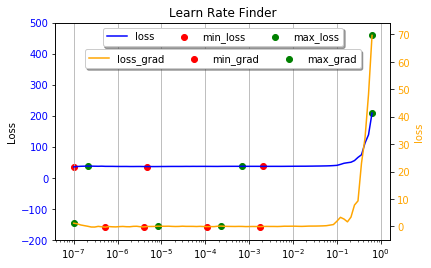

Optimun lr: 0.6309573650360107 
Lowest loss lr interval: [0.6309573650360107 , 0.06309573650360108]


In [0]:
lr =  find_optimal_lr(learn)

###Learn Search Methodfrom GitHub

In [0]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False): 
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

In [0]:
#  BACKUP
def find_optimal_lr(learn, plot=False):
   
    #Get loss values, corresponding gradients, and lr values from model.recorder
    loss = np.array(learn.recorder.losses)
    #assert(lr_diff < len(loss))  
    loss_grad = np.gradient(loss)
    lrs = learn.recorder.lrs
    # Transform lrs list to np array
    lrs = np.array(lrs, dtype='float32')
    # Create a DataFrame with the data
    df = pd.DataFrame(columns=['loss', 'loss_grad', 'lrs', 'min_loss', 'max_loss', 'min_grad', 'max_grad'])
    for i, (ls, lg, lr) in enumerate(zip(loss, loss_grad, lrs)):
      #print(ls,lg,lr)
      df.at[i,'loss'] = ls; df.at[i,'loss_grad'] = lg; df.at[i,'lrs'] = lr
    # Populate "min" and "max" columns for losses and gradients
    from scipy.signal import argrelextrema
    n=10  #4
    df['min_loss'] = df.iloc[argrelextrema(df.loss.values, np.less_equal, order=n)[0]]['loss']
    df['max_loss'] = df.iloc[argrelextrema(df.loss.values, np.greater_equal, order=n)[0]]['loss']
    df['min_grad'] = df.iloc[argrelextrema(df.loss_grad.values, np.less_equal, order=n)[0]]['loss_grad']
    df['max_grad'] = df.iloc[argrelextrema(df.loss_grad.values, np.greater_equal, order=n)[0]]['loss_grad']

    # Plot losses and loss gradients against lr values
    plt.figure()
    #figs, ax = plt.subplots(1,1)
    ax = plt.gca()

    color1 = 'blue'
    color2 = 'orange'

    ax.xaxis.grid(True)
    ax.set_ylabel('Loss')
    ax.set_title('Learn Rate Finder')
    ax.tick_params(axis='y', labelcolor=color1)
    ax.semilogx(df['lrs'], df.loss, c=color1 )

    ax.set_ylim([-200, 500])

    ax2 = ax.twinx()
    ax2.set_ylabel('loss', color=color2)
    ax2.semilogx(df['lrs'], df.loss_grad, c=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    ax.scatter(df['lrs'], df['min_loss'], c='r')
    ax.scatter(df['lrs'], df['max_loss'], c='g')
    ax2.scatter(df['lrs'], df['min_grad'], c='r')
    ax2.scatter(df['lrs'], df['max_grad'], c='g')
    plt.LogFormatter(labelOnlyBase=False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=3, fancybox=True, shadow=True)
    plt.show()
    
    optimun_lr_lower_bound = df.lrs.iloc[df.loss_grad.notna()[::-1].idxmax()]/10
    optimun_lr_upper_bound = df.lrs.iloc[df.loss.notna()[::-1].idxmax()]
    print('Optimun lr: {} '.format(optimun_lr_upper_bound))
    print('Lowest loss lr interval: [{} , {}]'.format(optimun_lr_upper_bound, optimun_lr_lower_bound))
    
    return optimun_lr_upper_bound  